## Deep Learning Lab
### Patent Classification Analysis
### Tools used:
        - Language: Python
        - Libraries: Keras, Sklearn, Pandas, Matplotlib
        - Open-source: Stanford NLP (Glove word embeddings), Google BERT
        - Dataset: Wipo-Alpha Patents dataset
    
Notebook consists of 4 parts:
1. Dataset parsing, cleaning and preprocessing;
2. Using GloVe word embeddings, building neural network and training the model;
3. Applying Domain specific word embeddings and training the model;
4. Applying pre-trained language model to classification task by fine-tuning 

# Part 1. Dataset parsing, cleaning and preprocessing
Before we start to build and train a neural network, we should first explore dataset. 
I decided to parse dataset by representing it as a tree. For this reason, I import ElementTree library.
First, I explore train dataset and try to extract files with an extension XML. Than I add relative paths of these files to list I declared before.

I decided to classify patents from  Wipo Alpha dataset on Sections level by Text attributes. How the section can be identified? Each patent document contains <ipcs> tag with an attribute 'mc' that contains following text: A01B00100 (example), in which the first letter (in this case A) identifies belonging to the section. Overall, there are following 8 sections in dataset: A, B, C, D, E, F, G, H
    





In [0]:
import xml.etree.ElementTree as ET
import os
import os.path
import re
import random

In [0]:
walk_dir = '/Deep Learning/dataset/train'
if not os.path.isdir(walk_dir):
    print('Error! Database has not been found! Try to find dir again')
    exit()
else: 
    print('Start working with dataset!')

Start working with dataset!


In [0]:
train_dataset_path = []
for child_nodes, parent_nodes, files in os.walk(walk_dir):
    for inner_file in files:
        path_file = child_nodes + os.sep + inner_file
        if path_file.endswith(".xml"):
            train_dataset_path.append(path_file)
random.shuffle(train_dataset_path)

- I parse only the first 10000 files of the train dataset. 
- As I decided to classify patents on Sections level, I get to nodes (in case of XML documents these are tags) with an attribute 'mc' and gather the first letter (index[0] from the list). Thus, I need text of the patents, I loop over the children of <ipcs> tag containing text of the node. 
    
- After all nodes have been looped, I append section identifier to first sublist, in the second sublist I keep the texts of patents. 
- If data has been somehow corrupted, I don't loop over them. Instead of it, I just print them.
- By using regular expression I filter the text by providing some instructions on replacing, splitting discrete symbols.   

In [ ]:
train_dataset_path = train_dataset_path[:10000]
data_list = [[],[]]
for entry_in in train_dataset_path:
    text = ' '
    try:
        tree = ET.parse(entry_in)
        base_root = tree.getroot()
        for node in base_root:
            if node.get('mc') is not None:
                section_item = node.get('mc')
                new_item = section_item[0]
            for sub_node in node:
                if(sub_node.tag == 'txt'):
                    text += sub_node.text + ' '
        
        data_list[0].append(new_item)
        data_list[1].append(text)
                       
    except:
        print('This data could be corrupted\n', entry_in)
    
    text = text.replace('\n', ' ') 
    regex = re.compile('[^a-zA-Z]')
    text = regex.sub(' ', text)
    text = re.sub('<[^>]+>', '', text)
    text = re.sub(r'\b\w{1,2}\b', '', text)
    text = " ".join(text.split()[:5000]).lower()

## Pandas
I have imported pandas to obtain some information about dataset by using pandas object - DataFrame. From the histogram below word frequencies in each section can be depicted. At this point, we can reveal which section has most dense vocabulary (number of words) and which one has less than other one. However, all these steps could be skipped, but we wouldn't be able to retain dataset details.

In [0]:
# ! pip install pandas
import pandas as pd

df_test = pd.DataFrame(data_list).T

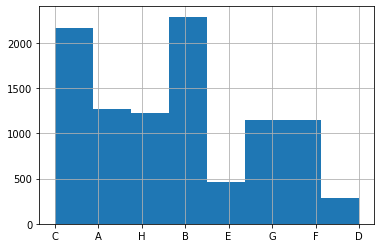

In [0]:
df_test[0].hist(bins=8)

Here following steps are done: 
- From the obtained data we want to retain all the rows, which is done by using DataFrame.head();
- We rename the columns headings to Section and Text respectively;
- The first column on the left side without title shows the number of document from the list (data).

In [0]:
df_test.head()
df_test.rename(columns={0:'Section', 1:'Text'})

,Section,Text
0,C,SUBSTITUTED IMIDAZOLE AS DUAL HISTAMINE H1 A...
1,C,HETEROCYCLIC GLYCYL BETA-ALANINE DERIVATIVES ...
2,A,METHOD OF DETECTING LENSES\nBackground of th...
3,H,TITLE : Balun and Associated Method for Conne...
4,B,Title of invention\nMethod for regulating of ...
...,...,...
9991,B,RIDER BAR SCREEN PANEL\nThis invention relat...
9992,B,MICROGRAPHIC DEVICE\nThis invention relates ...
9993,B,PULP FILTER OR WASHER AND SEALING FOR USE THE...
9994,B,METHOD OF LIQUID PHASE BONDING\nThis inventi...


At the one point, it could happen that some elements of the list could be filled with trash or could have had zero values (null). To avoid this and to get control over this element, I use the code below.

In [0]:
df_null = df_test.isnull()
df_null[df_null[1] == True]

,0,1


In [0]:
df_test.dropna(inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9996 entries, 0 to 9995
Data columns (total 2 columns):
0    9996 non-null object
1    9996 non-null object
dtypes: object(2)
memory usage: 156.3+ KB


In [ ]:
# the list overflows with empty value, I decided to figure out this 
print(data_list[1][9000])

Here we just assign list of sections and list of text into two variables data_x, data_y respectively.

In [0]:
data_x = df_test[0]
data_y = df_test[1]

# Keras
Keras is open-source neural nets library which also provides build-in tools and methods for preprocessing of the text. This includes preprocessing by importing from preprocessing.text and preprocessing.sequence following class and method: 
- Tokenizer
- Pad_sequences

## Preprocessing
Before we start with preprocessing, we define the maximum length, maximum number of words shoud be processed, determine how many words we consider for training phase and how many for validation phase of the learning.
We split dataset with 10000 elements into 9000 elements (train samples) and 1000 elements (validation samples)
### Tokenizer 
This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count.
### Pad_sequences
This function transforms a list of num_samples sequences (lists of integers) into a 2D Numpy array of shape (num_samples)

In [0]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

maxlen = 1000
max_words = 10000
training_samples = 9000
validation_samples = 1000
   
print('Step 1 --- Tokenization started..')
tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(data_y)
print('Tokenization done!')
print('Step 2 --- Converting text to sequence of tokens')
sequences = tokenizer.texts_to_sequences(data_y)
word_index = tokenizer.word_index
print('Number of unique items:', len(word_index))

Step 1 --- Tokenization started..
Tokenization done!
Step 2 --- Converting text to sequence of tokens
Number of unique items: 506054


In [0]:
import numpy as np
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(data_x)
print('Shape of data tensor: ', data.shape)
print('Shape of label tensor: ', labels.shape)
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Shape of data tensor:  (9996, 1000)
Shape of label tensor:  (9996,)


# Part 2. Using GloVe word embeddings, building neural net and training the model
### Parsing GloVe word-embeddings file
At this step we parse file containing 100 dimensional embedding vectors for 400.000 words to build an index that maps words to their vector representation.

In [0]:
embeddings_index = {}
with open("/Deep Learning/dataset/glove.6B/glove.6B.100d.txt") as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print('Found word vectors: ', len(embeddings_index))

Found word vectors:  400000


### Embedding matrix
After the GloVe file has been parsed we build an embedding matrix that we load into Embedding layer afterwards. We shape a matrix with size (max_words, embedding_dim). Each parameter we set up manually. 
In obtained matrix, each entry i contains (embedding_dim) dimensional vectro for the word of index i built during tokenization several steps before.

In [0]:
embedding_dim = 100
print('Preparing embedding_matrix..')
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
print('Embedding done!')

Preparing embedding_matrix..
Embedding done!


### Defining, building a model and learning it

#### Dense neural network
We start to define a dense layered deep network, which will be trained on several epochs (parameter is to be tuned). As activation function we use ReLu (Rectified Linear Unit) and Softmax (for output layer). Output has 8 neurons, as we have 8 sections, into which patent should be classfied.
#### Scikit-learn.preprocessing
From sklearn library we import LabelEncoder to represent our parameters y_train and y_val as integers, because Keras doesn't understand text data (only numbers). I have done this by encoding the paramenter and using to_categorical method.
#### Model hyperparameters
As optimizer we use rmsprop, as loss function categorical crossentrophy is used (case - multiclass classification) and accuracy has been chosen as metrics.

In [0]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.utils import np_utils, to_categorical
from sklearn.preprocessing import LabelEncoder

epoch = 11

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='softmax', name='prediction'))

model.summary()
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y = encoder.transform(y_train)
cat_y = to_categorical(encoded_y)

val_encoder = LabelEncoder()
val_encoder.fit(y_val)
val_encoded = val_encoder.transform(y_val)
cat_val_y = to_categorical(val_encoded)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(x_train, cat_y, epochs=epoch, batch_size=128, validation_data=(x_val, cat_val_y))
model.save_weights('pre_trained_glove_model.h5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 100)         1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 100000)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                3200032   
_________________________________________________________________
prediction (Dense)           (None, 8)                 264       
Total params: 4,200,296
Trainable params: 4,200,296
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 996 samples
Epoch 1/11
9000/9000 [==============================] - 4s 478us/step - loss: 3.7590 - acc: 0.2122 - val_loss: 2.0565 - val_acc: 0.1988
Epoch 2/11
9000/9000 [==============================] - 4s 

### Plotting the results
Here we can plot the training results obtained on the previous step. To do this, we import matplotlib library which provides plotting of data.

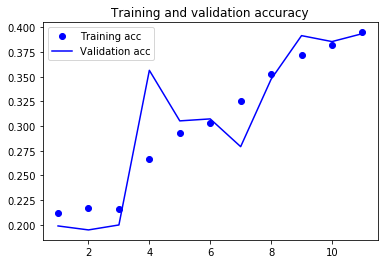

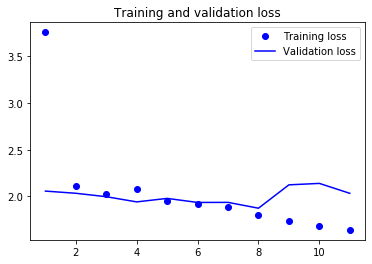

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Evaluating model from the training data on the test data
Learnt model with the help of training data should be evaluated on the test data. To be the hypothesis evaluated, we parse test dataset of Wipo Alpha. Implementation of the test dataset parser is the same as implementation of parser of train data.

In [0]:
test_dir = '/Deep Learning/dataset/test'
if not os.path.isdir(test_dir):
    print('Error! Database has not been found! Try to find dir again')
    exit()
else: 
    print('Start working with dataset!')


Start working with dataset!


In [0]:
test_dataset_path = []
for child_nodes, parent_nodes, files in os.walk(test_dir):
    for inner_file in files:
        path_file = child_nodes + os.sep + inner_file
        if path_file.endswith(".xml"):
            test_dataset_path.append(path_file)
random.shuffle(test_dataset_path)

In [0]:
test_dataset_path = test_dataset_path[:10000]
data_list = [[],[]]
for entry_in in test_dataset_path:
    try:
        tree = ET.parse(entry_in)
        base_root = tree.getroot()
        for node in base_root:
            if node.get('mc') is not None:
                section_item = node.get('mc')
                new_item = section_item[0]
            for sub_node in node:
                if(sub_node.tag == 'txt'):
                    text = sub_node.text
        
        data_list[0].append(new_item)
        data_list[1].append(text)
                       
    except:
        print('This data could be corrupted\n', entry_in)
    

This data could be corrupted
 /home/abror/University/Deep Learning/dataset/test/alphatest-G/G/06/F/017/US0106001_30082001.xml
This data could be corrupted
 /home/abror/University/Deep Learning/dataset/test/alphatest-A/A/61/K/007/AU0000791_11012001.xml


In [0]:
data_x = data_list[0]
data_y = data_list[1]

## Test data preprocessing
We should proceed tokenization of text in test dataset before we handle evaluation of the model. Tokenization is equal to tokenization of test data.

In [0]:
print('Tokenization of test data started..')
sequences = tokenizer.texts_to_sequences(data_y)
y_test = pad_sequences(sequences, maxlen=maxlen)
x_test = np.asarray(data_x)
print('Tokenization done!')

Tokenization of test data started..
Tokenization done!


Printing the dimension of y_test data for information

In [0]:
df = pd.DataFrame(data_list).T
y_test.shape

(9998, 1000)

In [0]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

# Part 3. Applying Domain specific embeddings and training the model
### Parsing domain specific word-embedding file

First, we parse vector extented file containing embedding vectors for 77276 words to build an index that maps words to their vector representation.


In [0]:
embeddings_index = {}
with open("/Deep Learning/dataset/patent-100.vec/patent-100.vec") as domain_file:
    try:
        for line in domain_file:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    except:
        pass
print('Found word vectors in domain specific dataset: ', len(embeddings_index))

Found word vectors in domain specific dataset:  77276


In [0]:
embedding_dim = 100
print('Preparing embedding_matrix..')
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
print('Embedding done!')

Preparing embedding_matrix..
Embedding done!


## Training the model (domain specific)
We have already built model with Glove embeddings. Now, our task is to train the model with domain specific word embeddings and control learning process with the same parameters of the model. 
Basically, the difference can be noticed when number of epochs is being changed, while other parameters remain the same.
### Weights 
For this subtask we save weights under domain_specific_model.h5 file

In [0]:
epoch = 11

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='softmax', name='prediction'))

model.summary()
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y = encoder.transform(y_train)
cat_y = to_categorical(encoded_y)

val_encoder = LabelEncoder()
val_encoder.fit(y_val)
val_encoded = val_encoder.transform(y_val)
cat_val_y = to_categorical(val_encoded)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(x_train, cat_y, epochs=epoch, batch_size=128, validation_data=(x_val, cat_val_y))
model.save_weights('domain_specific_model.h5')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 100)         1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 100000)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                3200032   
_________________________________________________________________
prediction (Dense)           (None, 8)                 264       
Total params: 4,200,296
Trainable params: 4,200,296
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 996 samples
Epoch 1/11
9000/9000 [==============================] - 4s 459us/step - loss: 2.6689 - acc: 0.2704 - val_loss: 1.9025 - val_acc: 0.2028
Epoch 2/11
9000/9000 [==============================] - 4s 

## Learning results

It can be seen from the numbers above that we approximately at 2-3% reach better results with domain specific word embeddings in comparance to learning with Glove.

Results can be obtained from the diagrams below. 
#### P.S.: cases when the model gets overfitted cannot be excluded

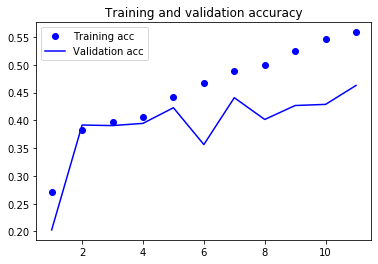

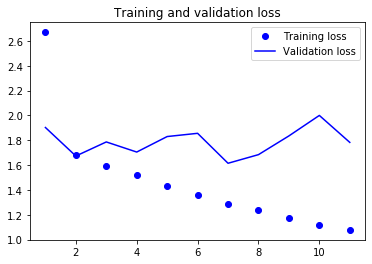

In [0]:
%matplotlib inline


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
test_dir = '/Deep Learning/dataset/test'
if not os.path.isdir(test_dir):
    print('Error! Database has not been found! Try to find dir again')
    exit()
else: 
    print('Start working with dataset!')


Start working with dataset!


In [0]:
df = pd.DataFrame(data_list).T
y_test.shape

(9998, 1000)

In [0]:
model.load_weights('domain_specific_model.h5')
model.evaluate(x_test, y_test)

# Part 4. Applying pre-trained language model to classification task by fine-tuning 

In [1]:
!pip install -q keras-bert keras-rectified-adam
!wget -q https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip -o uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [2]:
import tensorflow as tf
from keras_radam import RAdam
from tensorflow.keras import backend as K


sess = tf.Session()

SEQ_LEN = 128
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 1e-4

Using TensorFlow backend.


In [3]:
import os 

pretrained_path = 'uncased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')


os.environ['TF_KERAS'] = '1'
print('Success!')

Success!


In [0]:
from keras_bert import get_custom_objects

TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)
tf.contrib.distribute.initialize_tpu_system(resolver)
strategy = tf.contrib.distribute.TPUStrategy(resolver)

Model loading

In [5]:
from keras_bert import load_trained_model_from_checkpoint

model = load_trained_model_from_checkpoint(
        config_path,
        checkpoint_path,
        training=True,
        trainable=True,
        seq_len=SEQ_LEN,
    )

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
import codecs
from keras_bert import load_trained_model_from_checkpoint

token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)

Dataset definition

We use the same dataset for this subtask also. Here we are operating with training dataset

In [0]:
import numpy as np
from tqdm import tqdm
from keras_bert import Tokenizer
import random
import xml.etree.ElementTree as ET

tokenizer = Tokenizer(token_dict)

train_dir = '/Deep Learning/dataset/train'
train_dataset_path = []
for child_nodes, parent_nodes, files in os.walk(train_dir):
    for inner_file in files:
        path_file = child_nodes + os.sep + inner_file
        if path_file.endswith(".xml"):
            train_dataset_path.append(path_file)

labels = []
texts = []
def load_data(train_dir):
    global tokenizer
    global train_dataset_path
    train_dataset_path=train_dataset_path[:10000]
    data_list = [[],[]]
    global labels
    global texts
    for entry_in in train_dataset_path:
        text = ' '
        try:
          tree = ET.parse(entry_in)
          base_root = tree.getroot()
          for node in base_root:
              if node.get('mc') is not None:
                  section_item = node.get('mc')
                  new_item = section_item[0]
              for sub_node in node:
                  if(sub_node.tag == 'txt'):
                      text += sub_node.text + ' '
          
          labels.append(new_item)
          texts.append(text)
          ids, segments = tokenizer.encode(texts, max_len=SEQ_LEN)
          print(ids)
          labels.append(ids)
        except:
            print('This data could be corrupted\n', entry_in)
    items = list(zip(labels, texts))
    random.shuffle(items)
    # labels, texts = zip(*items)
    labels = np.array(labels)
    mod = labels.shape[0] % BATCH_SIZE
    if mod > 0:
        labels, texts = labels[:-mod], texts[:-mod]
    return [labels, np.zeros_like(labels)], np.array(texts)
  
train_path = os.path.join(os.path.dirname(train_dir), 'train')
train_x, train_y = load_data(train_path)

Evaluating on wipo alpha test dataset the learning results

In [0]:
tokenizer = Tokenizer(token_dict)

test_dir = '/Deep Learning/dataset/test'
labels = []
texts = []
for child_nodes, parent_nodes, files in os.walk(test_dir):
    for inner_file in files:
        path_file = child_nodes + os.sep + inner_file
        if path_file.endswith(".xml"):
            test_dataset_path.append(path_file)
random.shuffle(test_dataset_path)

def load_data(test_dir):
    global tokenizer
    test_dataset_path = test_dataset_path[:10000]
    data_list = [[],[]]
    for entry_in in test_dataset_path:
        text = ' '
        try:
          tree = ET.parse(entry_in)
          base_root = tree.getroot()
          for node in base_root:
              if node.get('mc') is not None:
                  section_item = node.get('mc')
                  new_item = section_item[0]
              for sub_node in node:
                  if(sub_node.tag == 'txt'):
                      text += sub_node.text + ' '
          
          data_list[0].append(new_item)
          data_list[1].append(text)
                      
        except:
            print('This data could be corrupted\n', entry_in)

    return data_list

test_path = os.path.join(os.path.dirname(test_dir), 'test')
test_x, test_y = load_data(test_path)

Building the model

In [0]:
from tensorflow.python import keras
from keras_radam import RAdam

with strategy.scope():
    inputs = model.inputs[:2]
    dense = model.get_layer('NSP-Dense').output
    outputs = keras.layers.Dense(units=8, activation='softmax')(dense)
    
    model = keras.models.Model(inputs, outputs)
    model.compile(
        RAdam(lr=LEARNING_RATE),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'],
    )

Initializing variables

In [0]:
import tensorflow as tf
import tensorflow.keras.backend as K

sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init_op = tf.variables_initializer(
    [v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables]
)
sess.run(init_op)

Training the model

We process with the same hyperparameters as we mentioned above

In [0]:
model.fit(
    train_x,
    train_y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
)

Making predictions for test dataset

In [0]:
predicts = model.predict(test_x, verbose=True).argmax(axis=-1)

Calculating and printing accuracy

In [0]:
print(np.sum(test_y == predicts) / test_y.shape[0])

Summary

In this notebook we have demonstrated classification of patents of Wipo Alpha Dataset. The whole task was divided into several subtasks and explanation for each step was provided.

Summing the complete work up, we can assume that reaching different accuracy can only be reached if various appropriate methods/techniques are taken into consideration (e.g. Glove/domain specific word embeddings/Pre-trained models)